In [73]:
import numpy as np
import pandas as pd

In [1]:
import create_detections

/Users/alvanchow/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
create_detections


<module 'create_detections' from '/Users/alvanchow/galvanize/xView_Capstone/baseline-1.1/inference/create_detections.py'>

In [7]:
%run create_detections.py

usage: create_detections.py [-h] [-c CHECKPOINT] [-cs CHIP_SIZE] [-o OUTPUT]
                            input
create_detections.py: error: the following arguments are required: input


SystemExit: 2

In [8]:
%run det_util.py

In [10]:
import tensorflow as tf

c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d, name='example')

with tf.Session() as sess:
    test =  sess.run(e)
    print (e.name) #example:0
    test = tf.get_default_graph().get_tensor_by_name("example:0")
    print (test) #Tensor("example:0", shape=(2, 2), dtype=float32)

example:0
Tensor("example:0", shape=(2, 2), dtype=float32)


In [11]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def generate_detections(checkpoint,images):
    
    print("Creating Graph...")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(checkpoint, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    boxes = []
    scores = []
    classes = []
    k = 0
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            for image_np in tqdm(images):
                image_np_expanded = np.expand_dims(image_np, axis=0)
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                box = detection_graph.get_tensor_by_name('detection_boxes:0')
                score = detection_graph.get_tensor_by_name('detection_scores:0')
                clss = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')
                # Actual detection.
                (box, score, clss, num_detections) = sess.run(
                        [box, score, clss, num_detections],
                        feed_dict={image_tensor: image_np_expanded})

                boxes.append(box)
                scores.append(score)
                classes.append(clss)
                
    boxes =   np.squeeze(np.array(boxes))
    scores = np.squeeze(np.array(scores))
    classes = np.squeeze(np.array(classes))

    return boxes,scores,classes

In [16]:
"""
Copyright 2018 Defense Innovation Unit Experimental
All rights reserved.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""


import numpy as np
import tensorflow as tf
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from tqdm import tqdm
import argparse
from det_util import generate_detections

"""
Inference script to generate a file of predictions given an input.
Args:
    checkpoint: A filepath to the exported pb (model) file.
        ie ("saved_model.pb")
    chip_size: An integer describing how large chips of test image should be
    input: A filepath to a single test chip
        ie ("1192.tif")
    output: A filepath where the script will save  its predictions
        ie ("predictions.txt")
Outputs:
    Writes a file specified by the 'output' parameter containing predictions for the model.
        Per-line format:  xmin ymin xmax ymax class_prediction score_prediction
        Note that the variable "num_preds" is dependent on the trained model 
        (default is 250, but other models have differing numbers of predictions)
"""

def chip_image(img, chip_size=(300,300)):
    """
    Segment an image into NxWxH chips
    Args:
        img : Array of image to be chipped
        chip_size : A list of (width,height) dimensions for chips
    Outputs:
        An ndarray of shape (N,W,H,3) where N is the number of chips,
            W is the width per chip, and H is the height per chip.
    """
    width,height,_ = img.shape
    wn,hn = chip_size
    images = np.zeros((int(width/wn) * int(height/hn),wn,hn,3))
    k = 0
    for i in tqdm(range(int(width/wn))):
        for j in range(int(height/hn)):
            
            chip = img[wn*i:wn*(i+1),hn*j:hn*(j+1),:3]
            images[k]=chip
            
            k = k + 1
    
    return images.astype(np.uint8)

def draw_bboxes(img,boxes,classes):
    """
    Draw bounding boxes on top of an image
    Args:
        img : Array of image to be modified
        boxes: An (N,4) array of boxes to draw, where N is the number of boxes.
        classes: An (N,1) array of classes corresponding to each bounding box.
    Outputs:
        An array of the same shape as 'img' with bounding boxes
            and classes drawn
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])

    idx = 0

    for i in range(len(boxes)):
        xmin,ymin,xmax,ymax = boxes[i]
        c = classes[i]

        draw.text((xmin+15,ymin+15), str(c))

        for j in range(4):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
    return source




In [25]:
# parser = argparse.ArgumentParser()
# parser.add_argument("-c","--checkpoint", default='pbs/model.pb', help="Path to saved model")
# parser.add_argument("-cs", "--chip_size", default=300, type=int, help="Size in pixels to chip input image")
# parser.add_argument("input", help="Path to test chip")
# parser.add_argument("-o","--output",default="predictions.txt",help="Filepath of desired output")
# args = parser.parse_args()
# %tb


In [39]:
filepath = '../../../xView_Capstone/train_images/2619.tif'

In [42]:
#Parse and chip images
arr = np.array(Image.open(filepath))
chip_size = (300,300)
images = chip_image(arr,chip_size)
print(images.shape)



100%|██████████| 9/9 [00:00<00:00, 22.69it/s]


(117, 300, 300, 3)


In [45]:
checkpoint = '../../../xView_Capstone/models_release_v_1.1/vanilla.pb'

In [46]:
#generate detections
boxes, scores, classes = generate_detections(checkpoint,images)

Creating Graph...


100%|██████████| 117/117 [00:47<00:00,  2.44it/s]


In [47]:

#Process boxes to be full-sized
width,height,_ = arr.shape
cwn,chn = (chip_size)
wn,hn = (int(width/cwn),int(height/chn))

In [48]:

num_preds = 250
bfull = boxes[:wn*hn].reshape((wn,hn,num_preds,4))
b2 = np.zeros(bfull.shape)
b2[:,:,:,0] = bfull[:,:,:,1]
b2[:,:,:,1] = bfull[:,:,:,0]
b2[:,:,:,2] = bfull[:,:,:,3]
b2[:,:,:,3] = bfull[:,:,:,2]

In [49]:

bfull = b2
bfull[:,:,:,0] *= cwn
bfull[:,:,:,2] *= cwn
bfull[:,:,:,1] *= chn
bfull[:,:,:,3] *= chn
for i in range(wn):
    for j in range(hn):
        bfull[i,j,:,0] += j*cwn
        bfull[i,j,:,2] += j*cwn

        bfull[i,j,:,1] += i*chn
        bfull[i,j,:,3] += i*chn

bfull = bfull.reshape((hn*wn,num_preds,4))

In [71]:

output_filepath = 'output_2619.csv'


In [72]:
'''
#only display boxes with confidence > .5
bs = bfull[scores > .5]
cs = classes[scores>.5]
s = args.input.split("/")[::-1]
draw_bboxes(arr,bs,cs).save("p_bboxes/"+s[0].split(".")[0] + ".png")
'''

with open(output_filepath,'w') as f:
    for i in range(bfull.shape[0]):
        for j in range(bfull[i].shape[0]):
            #box should be xmin ymin xmax ymax
            box = bfull[i,j]
            class_prediction = classes[i,j]
            score_prediction = scores[i,j]
            f.write('%d,%d,%d,%d,%d,%f \n' % \
                (box[0],box[1],box[2],box[3],int(class_prediction),score_prediction))
#             (f.write('%d %d %d %d %d %f \n' % \
#                 (box[0],box[1],box[2],box[3],int(class_prediction),score_prediction)))

In [70]:
list_boxes = []

with open ('output_2619.txt') as f:
    for line in f:
        list_boxes.append(line)
        
print(list_boxes)

['173 182 300 257 73 0.961261 \n', '155 248 224 294 73 0.723187 \n', '284 2 299 22 35 0.530687 \n', '208 0 246 15 35 0.522139 \n', '237 260 295 295 73 0.460056 \n', '130 42 168 71 35 0.450692 \n', '212 278 260 299 73 0.365544 \n', '208 0 246 15 73 0.305714 \n', '115 0 154 27 35 0.302898 \n', '125 8 165 38 35 0.289233 \n', '125 8 165 38 73 0.286331 \n', '248 20 294 50 35 0.257635 \n', '86 38 128 69 73 0.228117 \n', '209 43 256 75 35 0.222436 \n', '209 43 256 75 73 0.164198 \n', '129 234 240 300 73 0.160334 \n', '130 42 168 71 73 0.152792 \n', '173 11 214 40 35 0.141814 \n', '290 261 299 291 73 0.140363 \n', '177 236 207 257 73 0.123601 \n', '288 287 299 298 73 0.122905 \n', '209 274 279 299 73 0.121180 \n', '288 239 300 288 73 0.120663 \n', '17 252 192 300 73 0.113904 \n', '210 195 299 254 73 0.112597 \n', '277 224 300 263 73 0.112211 \n', '40 261 244 297 73 0.110073 \n', '35 230 175 300 73 0.109614 \n', '0 1 43 181 73 0.109036 \n', '199 0 231 8 35 0.109007 \n', '86 38 128 69 35 0.10888

In [64]:
!pwd

/Users/alvanchow/galvanize/xView_Capstone/baseline-1.1/inference


In [81]:
df = pd.read_csv('output_2619.csv', header=None)

In [82]:
df.columns = ['Xmin', 'Ymin', 'Xmax', 'Ymax', 'ClassID', 'Confidence']

In [83]:
df

,Xmin,Ymin,Xmax,Ymax,ClassID,Confidence
0,173,182,300,257,73,0.961261
1,155,248,224,294,73,0.723187
2,284,2,299,22,35,0.530687
3,208,0,246,15,35,0.522139
4,237,260,295,295,73,0.460056
5,130,42,168,71,35,0.450692
6,212,278,260,299,73,0.365544
7,208,0,246,15,73,0.305714
8,115,0,154,27,35,0.302898
9,125,8,165,38,35,0.289233


PIL image size (224, 224)


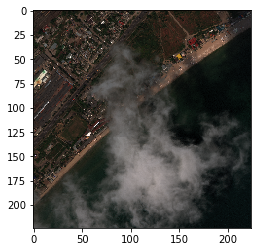

In [96]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
 
filename = '../../train_images/2619.tif'
# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
print('PIL image size',original.size)

matplotlib.patches.Rectangle((173,182), 50, 50, angle=0.0)
plt.imshow(original)

plt.show()
 

In [98]:


import matplotlib

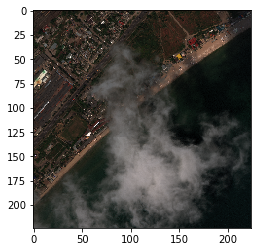

In [99]:
plt.imshow(original)

In [100]:
df.head()


,Xmin,Ymin,Xmax,Ymax,ClassID,Confidence
0,173,182,300,257,73,0.961261
1,155,248,224,294,73,0.723187
2,284,2,299,22,35,0.530687
3,208,0,246,15,35,0.522139
4,237,260,295,295,73,0.460056


In [117]:
list_labels = []

with open('../xview_class_labels.txt') as f:
    for line in f:
        list_labels.append(line.strip().split(':'))

In [118]:
list_labels[:5]

[['11', 'Fixed-wing Aircraft'],
 ['12', 'Small Aircraft'],
 ['13', 'Passenger/Cargo Plane'],
 ['15', 'Helicopter'],
 ['17', 'Passenger Vehicle']]

In [149]:
from collections import defaultdict

In [168]:
dict_class_labels = defaultdict(str)

for row in list_labels:
    for col in row:
        
        if len(col) <= 2:
            num = int(col)
            
        elif len(col) > 3:
            dict_class_labels[num] = col

In [169]:
dict_class_labels

defaultdict(str,
            {11: 'Fixed-wing Aircraft',
             12: 'Small Aircraft',
             13: 'Passenger/Cargo Plane',
             15: 'Helicopter',
             17: 'Passenger Vehicle',
             18: 'Small Car',
             20: 'Pickup Truck',
             21: 'Utility Truck',
             23: 'Truck',
             24: 'Cargo Truck',
             25: 'Truck Tractor w/ Box Trailer',
             26: 'Truck Tractor',
             27: 'Trailer',
             28: 'Truck Tractor w/ Flatbed Trailer',
             29: 'Truck Tractor w/ Liquid Tank',
             32: 'Crane Truck',
             33: 'Railway Vehicle',
             34: 'Passenger Car',
             35: 'Cargo/Container Car',
             36: 'Flat Car',
             37: 'Tank car',
             38: 'Locomotive',
             40: 'Maritime Vessel',
             41: 'Motorboat',
             42: 'Sailboat',
             44: 'Tugboat',
             45: 'Barge',
             47: 'Fishing Vessel',
             4

In [119]:
data = pd.DataFrame(list_labels)

In [121]:
data.head()

,0,1
0,11,Fixed-wing Aircraft
1,12,Small Aircraft
2,13,Passenger/Cargo Plane
3,15,Helicopter
4,17,Passenger Vehicle


In [123]:
for x in data:
    print(x)

0
1
